# 3. A little inspiration from our brain

In the previous part, we started with the intuition that if we could gradually tweak **_w_** and **_b_** such that the final output was closer to the actual values, then we could get closer and closer to a perfect answer.

Then we used a little bit of mathematics to devise an algorithm to automatically accomplish this.

In this section, we will look at more complex problem formulations and using automatic differentiation libraries so that we don't have to do the mathematics on our own.

But first, a little bit of initialization:

In [6]:
# Initialization stuff

!gdown https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
!unzip cgML.zip
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import torch 
from torch.autograd import Variable 
from scripts.helper import *
plt.style.use('ggplot')
# For reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

Downloading...
From: https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
To: /content/cgML.zip
35.4MB [00:00, 164MB/s]
Archive:  cgML.zip
   creating: scripts/
  inflating: scripts/helper.py       
   creating: scripts/__pycache__/
  inflating: scripts/__pycache__/helper.cpython-37.pyc  
   creating: .ipynb_checkpoints/
  inflating: .ipynb_checkpoints/1 - Facial Landmarks-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/1- Introduction - What is Machine Learning anyway_-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/2 - Automatic Learning-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/3 - A little inspiration from our brain-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/4 - Let's get visual!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/5 - It ain't convoluted!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/6 - Putting it all together-checkpoint.ipynb  
   creating: datasets/
   creating: datasets/MNIST/
   creating: datasets/MNIST/processed/
  infla

### Neurons

Our brain is comprised of billions of neurons. Each neuron receives a number of **_"input signals"_** from other neurons it is connected to. It has some intrinsic knowledge of the relative **_"importance"_** of these signals. Based on this, it has a final **_"output signal"_**.

Here's what a neuron looks like:

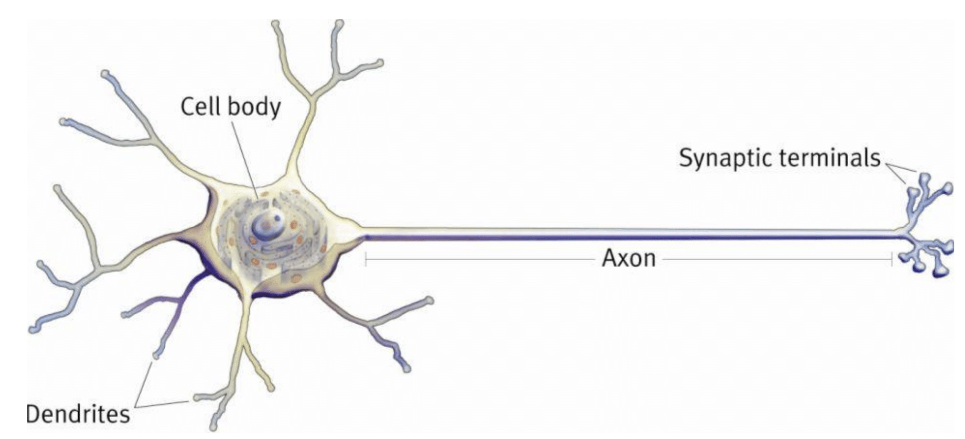

In [7]:
Image("images/neuron.png")

In the image above, the dendrites receive the **_"input signals"_**. The cell, has some inherent mechanism to attach some **_"importance"_** to the **_"input signals"_**. Finally the **_"output signal"_** is conveyed along the axon to the dendrites of other neurons connected to the synaptic terminals of the neuron shown in the picture.

Can we draw inspiration from biology? How would we model this mathematically?

Well, we could attach a **_"weight"_** to every **_"input signal"_** as a measure of its **_"importance"_**, and similar to our previous examples we could have a **_"bias"_** term as well.

The final piece, we could attach a **_non-linear_** function that takes the linear part of weights and bias terms and passes it through a **_non-linear_** function.

Why do we need a **_non-linear_** function? Because without some form of non-linearity, any combination of our **_"artificial neurons"_** could only learn weights and bias terms that can ultimately model only a linear function.

Here's what an **_"artificial neuron"_** might look like:

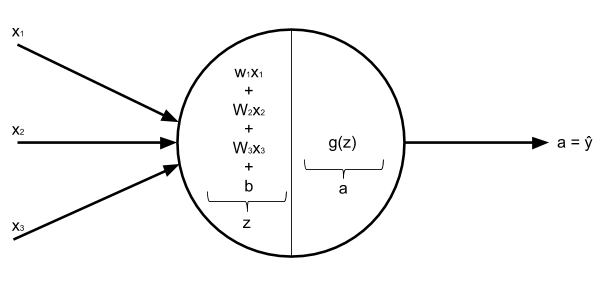

In [8]:
Image("images/artificial-neuron.png")

In the diagram above x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub> are the inputs to the artificial neuron. w<sub>1</sub>, w<sub>2</sub>, w<sub>3</sub> are the weights that represent the **_"importance"_** of x<sub>1</sub>, x<sub>2</sub>, and x<sub>3</sub>. b is the bias term. Together, we group this linear part of the neuron and call it z. We then apply a non-linear function g to the linear part to produce the activation value from this neuron. The non-linear function is also called the **_activation function_**.

Now that our neuron can take multiple inputs, let's try our housing price prediction with more variables. In additions to the number of bedrooms, we will also include the number of bathrooms and the distance (in kilometers) from the closest train station.

We have defined a function called **_get_house_price_** to get the price of a house given the number of bedrooms, bathrooms and the distance in kilometers.

Below, we generate some random **_training_** and **_validation_** datasets. The **_training_** dataset will be used to train the **_"model"_** (in this case a single artificial neuron). While the **_validation_** dataset will be used to see how the model performs on unseen data.

In [9]:


training_X = []
training_y = []

validation_X = []
validation_y = []

# Generate 500 random training samples
for _ in range(500):
    found_unique_permutation = False
    while not found_unique_permutation:
        bedrooms = random.randint(1, 6)
        bathrooms = random.randint(1, 6)
        distance = random.randint(1, 20)
        price = get_house_price(bedrooms=bedrooms, bathrooms=bathrooms, distance_to_station=distance)
        
        # Normalize by converting to float between 0 and 1
        bedrooms = bedrooms / 6

        # Normalize by converting to float between 0 and 1
        bathrooms = bathrooms / 6
                
        # Normalize by converting to float between 0 and 1
        distance = distance / 20
        
        # Normalize  price as a fraction of a million
        price = price / 1000000
        
        X = [bedrooms, bathrooms, distance]
        if X not in training_X:
            training_X.append(X)
            training_y.append(price)
            found_unique_permutation = True
            
# Generate 100 random validation samples
for _ in range(100):
    found_unique_permutation = False
    while not found_unique_permutation:
        bedrooms = random.randint(1, 6)
        bathrooms = random.randint(1, 6)
        distance = random.randint(1, 20)
        price = get_house_price(bedrooms=bedrooms, bathrooms=bathrooms, distance_to_station=distance)
        
        # Normalize by converting to float between 0 and 1
        bedrooms = bedrooms / 6

        # Normalize by converting to float between 0 and 1
        bathrooms = bathrooms / 6
                
        # Normalize by converting to float between 0 and 1
        distance = distance / 20
        
        # Normalize  price as a fraction of a million
        price = price / 1000000
        
        X = [bedrooms, bathrooms, distance]
        if X not in training_X and X not in validation_X:
            validation_X.append(X)
            validation_y.append(price)
            found_unique_permutation = True

            
# Let's convert the lists to arrays
training_X = np.asarray(training_X)
training_y = np.reshape(np.asarray(training_y), (-1, 1))
validation_X = np.asarray(validation_X)
validation_y = np.reshape(np.asarray(validation_y), (-1, 1))

# Look at the data
print(training_X)
print(training_y)
print(training_y.shape)

[[0.66666667 0.66666667 0.1       ]
 [0.5        0.83333333 0.8       ]
 [0.66666667 0.5        0.8       ]
 ...
 [0.83333333 1.         0.5       ]
 [1.         0.83333333 0.25      ]
 [0.83333333 0.16666667 0.4       ]]
[[ 1.091791]
 [ 0.633791]
 [ 0.733791]
 [ 0.831791]
 [ 1.015791]
 [ 0.145791]
 [ 0.545791]
 [ 0.597791]
 [ 1.143791]
 [ 1.097791]
 [ 0.693791]
 [ 1.281791]
 [ 1.005791]
 [ 1.241791]
 [ 1.119791]
 [ 1.513791]
 [ 1.093791]
 [ 0.593791]
 [ 1.231791]
 [ 1.059791]
 [ 0.455791]
 [ 0.143791]
 [ 1.247791]
 [ 0.765791]
 [ 0.989791]
 [ 0.967791]
 [ 0.869791]
 [ 0.503791]
 [ 0.387791]
 [ 0.919791]
 [ 1.325791]
 [-0.010209]
 [ 1.161791]
 [ 0.809791]
 [ 0.417791]
 [ 0.987791]
 [ 0.871791]
 [ 0.045791]
 [ 0.117791]
 [ 1.331791]
 [ 0.387791]
 [ 0.459791]
 [ 0.593791]
 [ 0.897791]
 [ 0.659791]
 [ 0.189791]
 [ 1.369791]
 [ 0.231791]
 [ 1.297791]
 [ 0.721791]
 [-0.054209]
 [ 0.303791]
 [ 1.033791]
 [ 0.791791]
 [ 0.609791]
 [ 0.415791]
 [ 0.803791]
 [ 0.255791]
 [ 0.497791]
 [ 1.381791

This time it is not straightforward to spot any patterns from the data!

Let's see if a single artificial neuron can solve this for us!

In [10]:
X_train = Variable(torch.Tensor(training_X))
y_train = Variable(torch.Tensor(training_y))

# Our "model"
class LinearRegressionModel(torch.nn.Module): 
    def __init__(self): 
        super(LinearRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)  # Three in and one out 
  
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred
    
    def weights(self):
        return self.linear.weight.detach().numpy(), self.linear.bias.detach().numpy()
    
# Model instance 
model = LinearRegressionModel() 
  
cost = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
for epoch in range(2000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    y_hat = model(X_train)
  
    # Compute and print loss 
    loss = cost(y_hat, y_train) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    print('epoch {}, loss {}'.format(epoch, loss.data)) 

epoch 0, loss 1.737216591835022
epoch 1, loss 0.6828002333641052
epoch 2, loss 0.2952002286911011
epoch 3, loss 0.15178118646144867
epoch 4, loss 0.09781010448932648
epoch 5, loss 0.07663599401712418
epoch 6, loss 0.06751663982868195
epoch 7, loss 0.0628565326333046
epoch 8, loss 0.059873342514038086
epoch 9, loss 0.05754692852497101
epoch 10, loss 0.05550237372517586
epoch 11, loss 0.05360102653503418
epoch 12, loss 0.05179078131914139
epoch 13, loss 0.05005127191543579
epoch 14, loss 0.04837376996874809
epoch 15, loss 0.04675387218594551
epoch 16, loss 0.04518880695104599
epoch 17, loss 0.04367641359567642
epoch 18, loss 0.042214807122945786
epoch 19, loss 0.0408022440969944
epoch 20, loss 0.03943706303834915
epoch 21, loss 0.0381176732480526
epoch 22, loss 0.036842528730630875
epoch 23, loss 0.0356101393699646
epoch 24, loss 0.03441907837986946
epoch 25, loss 0.03326795622706413
epoch 26, loss 0.03215542808175087
epoch 27, loss 0.03108019381761551
epoch 28, loss 0.030041011050343513

Now that our model is trained, lets try it on some data:

In [11]:
# Let's try our model on the first 5 rows of our validation data
X_validation_subset = Variable(torch.Tensor(validation_X[0:5,:]))
y_hat_validation_subset = model(X_validation_subset).detach().numpy()
print("Predicted:")
print(y_hat_validation_subset * 1000000)
print("Actual:")
print(validation_y[0:5,:] * 1000000)

Predicted:
[[ 369793.38526726]
 [ 713792.44327545]
 [ 409792.42324829]
 [ 783790.23075104]
 [1321788.90705109]]
Actual:
[[ 369791.]
 [ 713791.]
 [ 409791.]
 [ 783791.]
 [1321791.]]


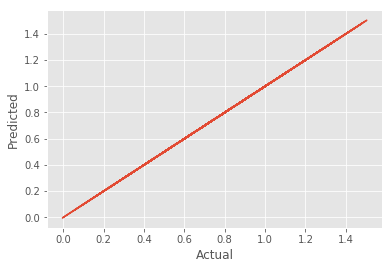

In [12]:
# Let's plot predicted vs actual
validation_X = Variable(torch.Tensor(validation_X)) 
validation_y_hat = model(validation_X).detach().numpy()
# Let's plot predictions against actuals
# This should be a 45 degree line
x_axis = validation_y
y_axis = validation_y_hat
# Plotting first column vs second column
plt.plot(x_axis, y_axis)
# Label the axes
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

We see from the above, that a single neuron has not done a bad job of learning from our data.

### What's a model anyway?

In Machine Language lingo, we often talk about a model. As a matter of fact, what we just did in this notebook was to **_train a model_**. So what's a model anyway? A model is a graph of computations.

In our single unit neuron, the only calculation was a linear calculation. Thus our computation graph consisted of only one node, with 3 inputs and one output.

But we can connect multiple nodes such that the output from one goes in as the input of the next. Thus, each node maintains a set of weights.

When we **_feed_** the input, a chain of calculations happens. Thus we can say that a model is nothing more than a set of weights, and a graph defining the chaining of computations.

To convince ourselves of this, let's extract the weights from our model:

In [13]:
weights, bias = model.weights()

def predict(bedrooms, bathrooms, distance):
    return 1000000 * (weights[0,0] * bedrooms/6 + weights[0,1] * bathrooms/6 + weights[0,2]*distance/20 + bias[0])

actual = get_house_price(bedrooms=4, bathrooms=3, distance_to_station=2)
predicted = predict(4, 3, 2)
print("Actual price {}".format(actual))
print("Predicted price from weights {}".format(predicted))
variable = Variable(torch.Tensor([4/6,3/6,2/20])) 
validation_y_hat = model(variable).detach().numpy()[0] * 1000000
print("Predicted price from model {}".format(validation_y_hat))

Actual price 1041791
Predicted price from weights 1041791.3268009822
Predicted price from model 1041791.3198471069


From the above we see that the model prediction is nothing more than the execution of a computation graph given known weights.

### Artificial Neural Networks

Can we do a better job by creating a **_network_** of neurons, kind of like our brain?

What would that look like?

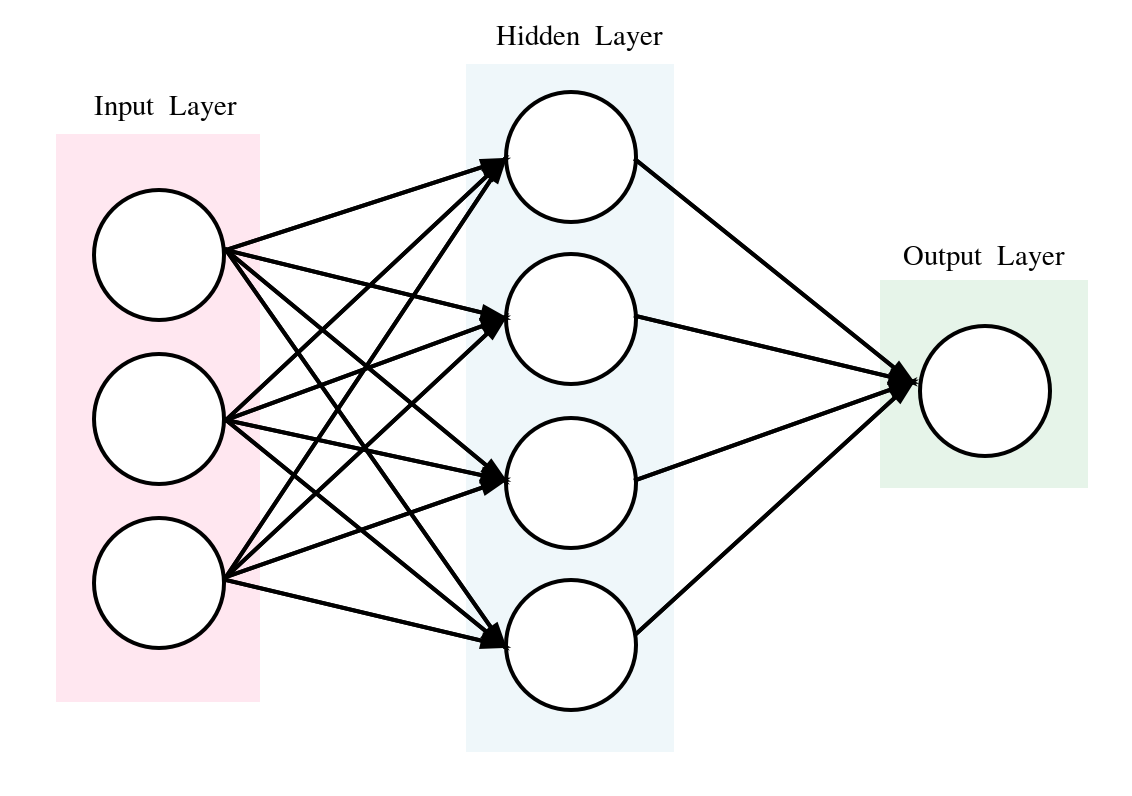

In [14]:
Image("images/artificial-neural-network.png")

That's the network! Let's code it up:

In [15]:
n_in, n_h, n_out = 3, 4, 1
# Here we will use the Sequential model api for a cleaner implementation
model = torch.nn.Sequential(torch.nn.Linear(n_in, n_h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_h, n_out))

cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Training loop
for epoch in range(50000): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    y_hat = model(X_train)
  
    # Compute and print loss 
    loss = cost(y_hat, y_train) 
  
    # Zero gradients, perform a backward pass,  
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    print('epoch {}, loss {}'.format(epoch, loss.data)) 

epoch 0, loss 0.42847225069999695
epoch 1, loss 0.22465933859348297
epoch 2, loss 0.13891953229904175
epoch 3, loss 0.10967124253511429
epoch 4, loss 0.10060045123100281
epoch 5, loss 0.09719599038362503
epoch 6, loss 0.09514837712049484
epoch 7, loss 0.09340047836303711
epoch 8, loss 0.09171953797340393
epoch 9, loss 0.09005699306726456
epoch 10, loss 0.08840285986661911
epoch 11, loss 0.08675505965948105
epoch 12, loss 0.08511307835578918
epoch 13, loss 0.08347678929567337
epoch 14, loss 0.0818461999297142
epoch 15, loss 0.08022136986255646
epoch 16, loss 0.07860243320465088
epoch 17, loss 0.0769895613193512
epoch 18, loss 0.07538299262523651
epoch 19, loss 0.07378299534320831
epoch 20, loss 0.07218991219997406
epoch 21, loss 0.0706041008234024
epoch 22, loss 0.06902597099542618
epoch 23, loss 0.06745599210262299
epoch 24, loss 0.06589461863040924
epoch 25, loss 0.06434239447116852
epoch 26, loss 0.06279987096786499
epoch 27, loss 0.06126759946346283
epoch 28, loss 0.0597462058067321

That's it! Simple. Let's see if we get better results?

In [16]:
# Let's try our model on the first 5 rows of our validation data
X_validation_subset = Variable(torch.Tensor(validation_X[0:5,:]))
y_hat_validation_subset = model(X_validation_subset).detach().numpy()
print("Predicted:")
print(y_hat_validation_subset * 1000000)
print("Actual:")
print(validation_y[0:5,:] * 1000000)

Predicted:
[[ 369792.22297668]
 [ 713791.78762436]
 [ 409791.64838791]
 [ 783790.64798355]
 [1321789.97993469]]
Actual:
[[ 369791.]
 [ 713791.]
 [ 409791.]
 [ 783791.]
 [1321791.]]


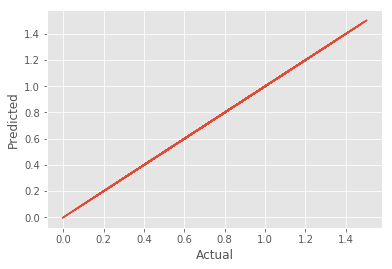

In [17]:
# Let's plot predicted vs actual
validation_X = Variable(torch.Tensor(validation_X)) 
validation_y_hat = model(validation_X).detach().numpy()
# Let's plot predictions against actuals
# This should be a 45 degree line
x_axis = validation_y
y_axis = validation_y_hat
# Plotting first column vs second column
plt.plot(x_axis, y_axis)
# Label the axes
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

## What just happened?

1. We started of by looking at how a neuron in a human brain works
2. We then tried to think of how we could model a single neuron mathematically.
3. We tested our formulation of a single neuron by training it on slightly more complex (multi-variate) data.
4. We understood that, from an inference perspective, a trained model is nothing more than a graph of computation that uses weights learned during the training phase.
5. We formulated what a network of neurons would look like.
6. We used Pytorch to create and train simple Artificial Neural Networks.

## But this is just toy data!

I hope you've enjoyed the journey so far. We started with intuition, took a brief dive into theory, then zoomed back out into using the Pytorch library to code up simple Artificial Neural Networks on toy data.

In the next section we are going to do something useful!

We're going to code up an ANN that can recognize digits in images.